In [1]:
import numpy as np
import re

from os.path import join
import os
from shutil import copyfile

from collections import namedtuple
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model
from scipy.sparse import hstack

from sklearn.model_selection import cross_val_predict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from test_with_origin import read_file, restore_order, read_write_embeddings, get_shuffled_inds

In [3]:
files_root = 'files_root'
filename_1gram = "alldata-id_p1gram.txt"
filename_3gram = "alldata-id_p3gram.txt"
filename_embedding_train = "train_vectors.txt"
filename_embedding_test = "test_vectors.txt"

# train set contains the first 25000 items in both files
docs_1gram = read_file(join(files_root, filename_1gram), 0, 25000)
docs_3gram = read_file(join(files_root, filename_3gram), 0, 25000)
# match and retrieve the correct order
train_order = restore_order(docs_1gram, docs_3gram)

# test set contains the second 25000 items in both files
docs_1gram = read_file(join(files_root, filename_1gram), 25000, 50000)
docs_3gram = read_file(join(files_root, filename_3gram), 25000, 50000)
# match and retrieve the correct order
test_order = restore_order(docs_1gram, docs_3gram)

# copy 1gram file from files_root to the root
copyfile(join(files_root, filename_1gram), filename_1gram)

'alldata-id_p1gram.txt'

In [4]:
# COPIED AND MODIFIED FROM ensemble.py
# get BON vectors

#params here

ngram_lower=1
ngram_upper=3

######################################################################

print('Reading documents')

SentimentDocument = namedtuple('SentimentDocument', 'words tags split sentiment')
alldocs = []  # will hold all docs in original order
filename='alldata-id_p1gram.txt'

with open(filename, encoding='utf-8') as alldata:
    for line_no, line in enumerate(alldata):
        tokens = line.split()
        words = tokens[1:]
        tags = [line_no] # `tags = [tokens[0]]` would also work at extra memory cost
        split = ['train','test','extra','extra'][line_no//25000]  # 25k train, 25k test, 25k extra
        sentiment = [1.0, 0.0, 1.0, 0.0, None, None, None, None][line_no//12500] # [12.5K pos, 12.5K neg]*2 then unknown
        alldocs.append(SentimentDocument(words, tags, split, sentiment))
    
train_docs = [doc for doc in alldocs if doc.split == 'train']
test_docs = [doc for doc in alldocs if doc.split == 'test']

########################################################################################

print('Extracting features')

count_vect = CountVectorizer(tokenizer=lambda text: text ,preprocessor=lambda text:text, binary=True,ngram_range=(ngram_lower,ngram_upper))
X_train_NB = count_vect.fit_transform([x.words for x in train_docs])
Y_train = [doc.sentiment for doc in train_docs]


print('Calculating probabilities')

nb=naive_bayes.BernoulliNB()
nb.fit(X_train_NB,Y_train)
prob=nb.feature_log_prob_ #index 0 is positive

r=prob[0]-prob[1]

print('Weighing features')
X_train_bon=X_train_NB.multiply(r).tocsr()

X_test_bon=count_vect.transform([x.words for x in test_docs])
X_test_bon=X_test_bon.multiply(r).tocsr()

Y_test=[int(doc.sentiment) for doc in test_docs]
############################################################################################


Reading documents
Extracting features
Calculating probabilities
Weighing features


## Original order (wrong order)

In [5]:
# read the pretrained embeddings and save them in a particular order in a new file
read_write_embeddings(join(files_root, filename_embedding_train), 
    filename_embedding_train, np.arange(25000))
read_write_embeddings(join(files_root, filename_embedding_test), 
    filename_embedding_test, np.arange(25000))

In [6]:
# COPIED FROM ensemble.py
# read the embeddings

def read_embeddings(filename):
    X=[]
    with open(filename) as file:
        for line in file:
            vector = line.split()[1:]
            vector = np.array(vector)
            vector = vector.astype(np.float64)
            X.append(vector)
    return np.array(X)

X_train_embedding = read_embeddings('train_vectors.txt')
X_test_embedding = read_embeddings('test_vectors.txt')

In [7]:
X_train = hstack((X_train_bon, X_train_embedding)).tocsr()
X_test = hstack((X_test_bon, X_test_embedding)).tocsr()

In [8]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [9]:
w = lr.coef_[0]
w_bon = w[:X_train_bon.shape[1]]
w_emb = w[-X_train_embedding.shape[1]:]
b_original = lr.intercept_[0]

In [10]:
df_original = pd.DataFrame({
    "logit_BON": X_test_bon.dot(w_bon),
    "logit_DV_ngrams_cosine": X_test_embedding.dot(w_emb),
    "label": Y_test
})

In [11]:
print(b_original)
border_original = np.array([[-100, -b_original + 100], [100, -b_original - 100]])

0.03305235109745273


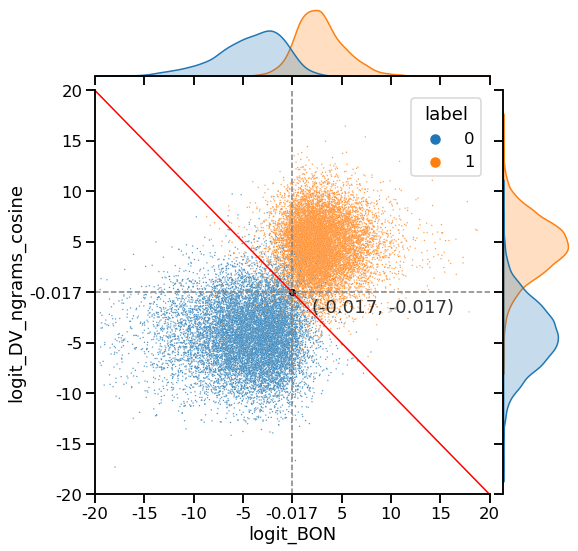

In [12]:
sns.set_context("talk")

plot_original = sns.jointplot(data=df_original.sample(frac=1.), x="logit_BON", y="logit_DV_ngrams_cosine", hue="label", 
    joint_kws={"s": 2, "alpha": 0.8}, height=8)
plot_original.ax_joint.plot(border_original[:, 0], border_original[:, 1], c='r', linewidth=1.5)
plot_original.ax_joint.plot([[-20, -b_original/2], [20, -b_original/2]], [[-b_original/2, -20], [-b_original/2, 20]], '--', c='gray', linewidth=1.5)
plot_original.ax_joint.scatter([-b_original/2], [-b_original/2], s=30, c='black')
plot_original.ax_joint.text(2, -2, f"({-b_original/2:.3f}, {-b_original/2:.3f})", alpha=0.8)
plot_original.ax_joint.set(xlim=[-20, 20], ylim=[-20, 20])
coors_original = [-20, -15, -10, -5, np.round(-b_original/2, 3), 5, 10, 15, 20]
plot_original.ax_joint.set_xticks(coors_original)
plot_original.ax_joint.set_xticklabels(coors_original)
plot_original.ax_joint.set_yticks(coors_original)
plot_original.ax_joint.set_yticklabels(coors_original)
plot_original.savefig("figures/logit_dist_original.jpg")

In [13]:
df_original["Correctly Classified"] = df_original.eval("(logit_BON + logit_DV_ngrams_cosine + @b_original > 0) * 1 == label")

# Separate models
lr.fit(X_train_bon, Y_train)
df_original["BON_only"] = lr.decision_function(X_test_bon)
print(lr.intercept_)

lr.fit(X_train_embedding, Y_train)
df_original["DV_ngrams_cosine_only"] = lr.decision_function(X_test_embedding)
print(lr.intercept_)

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
sns.histplot(data=df_original, x="BON_only", hue="label", kde=True, ax=axs[0])
sns.histplot(data=df_original, x="DV_ngrams_cosine_only", hue="label", kde=True, ax=axs[1])
axs[1].set_ylabel(None)
fig.savefig("figures/logit_dist_separate.jpg")


## Correct order

In [14]:
read_write_embeddings(join(files_root, filename_embedding_train), 
    filename_embedding_train, train_order)
read_write_embeddings(join(files_root, filename_embedding_test), 
    filename_embedding_test, test_order)

In [15]:
# read embeddings in the correct order
X_train_embedding = read_embeddings('train_vectors.txt')
X_test_embedding = read_embeddings('test_vectors.txt')

# stack
X_train = hstack((X_train_bon, X_train_embedding)).tocsr()
X_test = hstack((X_test_bon, X_test_embedding)).tocsr()

In [16]:
lr = linear_model.LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression()

In [17]:
w = lr.coef_[0]
w_bon = w[:X_train_bon.shape[1]]
w_emb = w[-X_train_embedding.shape[1]:]
b_correct = lr.intercept_[0]

In [18]:
df_correct = pd.DataFrame({
    "logit_BON": X_test_bon.dot(w_bon),
    "logit_DV_ngrams_cosine": X_test_embedding.dot(w_emb),
    "label": Y_test
})

In [19]:
print(b_correct)
border_correct = np.array([[-100, -b_correct + 100], [100, -b_correct - 100]])

0.005410893111549854


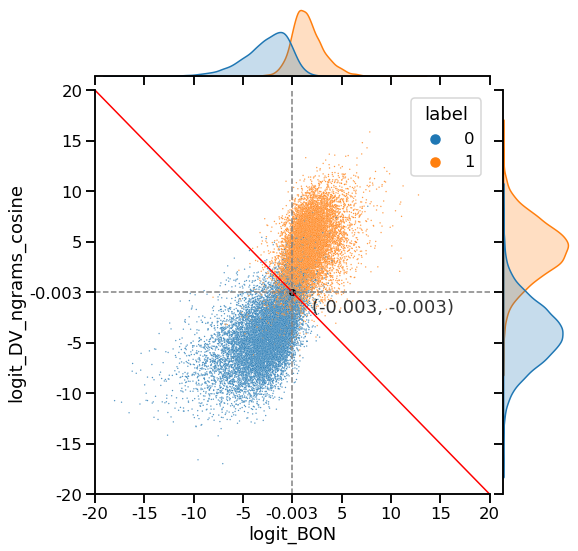

In [20]:
sns.set_context("talk")

plot_correct = sns.jointplot(data=df_correct.sample(frac=1.), x="logit_BON", y="logit_DV_ngrams_cosine", hue="label", 
    joint_kws={"s": 2, "alpha": 0.8}, height=8)
plot_correct.ax_joint.plot(border_correct[:, 0], border_correct[:, 1], c='r', linewidth=1.5)
plot_correct.ax_joint.plot([[-20, -b_correct/2], [20, -b_correct/2]], [[-b_correct/2, -20], [-b_correct/2, 20]], '--', c='gray', linewidth=1.5)
plot_correct.ax_joint.scatter([-b_correct/2], [-b_correct/2], s=30, c='black')
plot_correct.ax_joint.text(2, -2, f"({-b_correct/2:.3f}, {-b_correct/2:.3f})", alpha=0.8)
plot_correct.ax_joint.set(xlim=[-20, 20], ylim=[-20, 20])
coors_correct = [-20, -15, -10, -5, np.round(-b_correct/2, 3), 5, 10, 15, 20]
plot_correct.ax_joint.set_xticks(coors_correct)
plot_correct.ax_joint.set_xticklabels(coors_correct)
plot_correct.ax_joint.set_yticks(coors_correct)
plot_correct.ax_joint.set_yticklabels(coors_correct)
plot_correct.savefig("figures/logit_dist_correct.jpg")

In [21]:
df_correct["Correctly Classified"] = df_correct.eval("(logit_BON + logit_DV_ngrams_cosine + @b_correct > 0) * 1 == label")

In [22]:
# Compare original and correct order
df_original["Concatenation"] = "Original"
df_correct["Concatenation"] = "Correct"
df_all = pd.concat([df_original, df_correct])

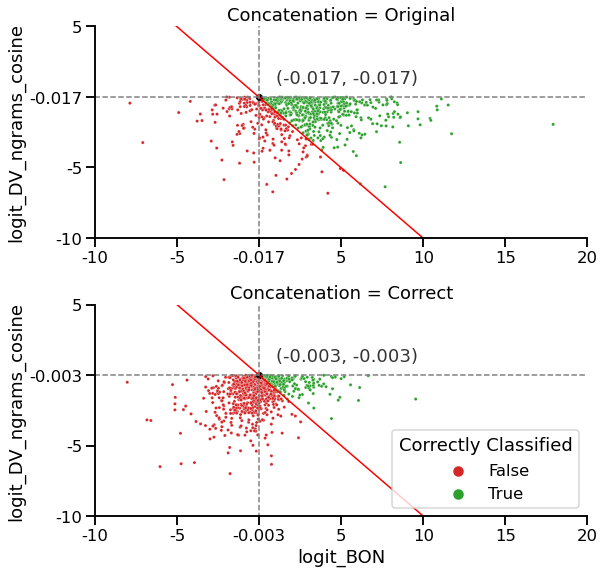

In [23]:
plot_compare = sns.FacetGrid(data=df_all.query("logit_DV_ngrams_cosine < 0 and label == 1"), 
    # dots are filtered as if the borders of sub-models are 0, for convenience (indistinguishable in the plot)
    row="Concatenation", height=4, aspect=2, sharex=False, sharey=False, legend_out=False)
plot_compare.map_dataframe(sns.scatterplot, x="logit_BON", y="logit_DV_ngrams_cosine",
    hue="Correctly Classified", palette=sns.color_palette(n_colors=4)[:-3:-1], s=10)

for ax, intercept_line, b, coors in zip(plot_compare.axes.flat, [border_original, border_correct],
        [b_original, b_correct], [coors_original, coors_correct]):
    ax.plot(intercept_line[:, 0], intercept_line[:, 1], c='r', linewidth=1.5)
    ax.plot([[-25, -b/2], [25, -b/2]], [[-b/2, -25], [-b/2, 25]], '--', c='gray', linewidth=1.5)
    ax.scatter([-b/2], [-b/2], s=30, c='black')
    ax.text(1, 1, f"({-b/2:.3f}, {-b/2:.3f})", alpha=0.8)
    ax.set_yticks(coors)
    ax.set_yticklabels(coors)
    ax.set_xticks(coors)
    ax.set_xticklabels(coors)
    ax.set(xlim=[-10, 20], ylim=[-10, 5])
    ax.set_ylabel("logit_DV_ngrams_cosine")
plot_compare.axes_dict["Correct"].legend(title="Correctly Classified", loc=4)
plot_compare.axes_dict["Correct"].set_xlabel("logit_BON")
plot_compare.savefig("figures/logit_dist_compare_a.jpg")

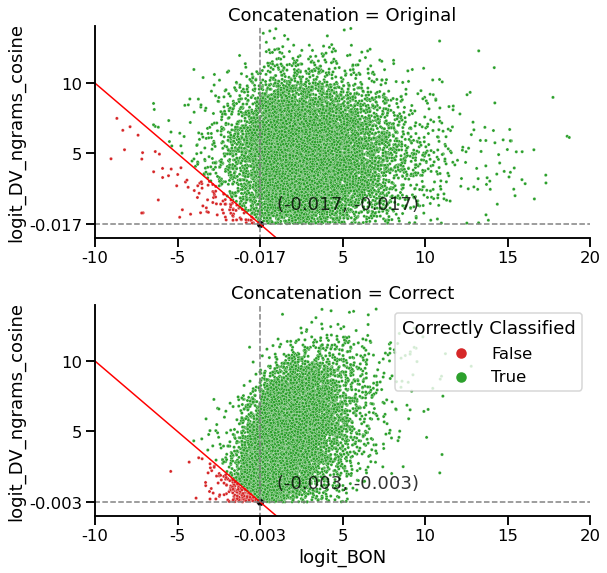

In [24]:
plot_compare = sns.FacetGrid(data=df_all.query("logit_DV_ngrams_cosine > 0 and label == 1"), 
    # dots are filtered as if the borders of sub-models are 0, for convenience (indistinguishable in the plot)
    row="Concatenation", height=4, aspect=2, sharex=False, sharey=False, legend_out=False)
plot_compare.map_dataframe(sns.scatterplot, x="logit_BON", y="logit_DV_ngrams_cosine",
    hue="Correctly Classified", palette=sns.color_palette(n_colors=4)[:-3:-1], s=10)

for ax, intercept_line, b, coors in zip(plot_compare.axes.flat, [border_original, border_correct],
        [b_original, b_correct], [coors_original, coors_correct]):
    ax.plot(intercept_line[:, 0], intercept_line[:, 1], c='r', linewidth=1.5)
    ax.plot([[-25, -b/2], [25, -b/2]], [[-b/2, -25], [-b/2, 25]], '--', c='gray', linewidth=1.5)
    ax.scatter([-b/2], [-b/2], s=30, c='black')
    ax.text(1, 1, f"({-b/2:.3f}, {-b/2:.3f})", alpha=0.8)
    ax.set_yticks(coors)
    ax.set_yticklabels(coors)
    ax.set_xticks(coors)
    ax.set_xticklabels(coors)
    ax.set(xlim=[-10, 20], ylim=[-1, 14])
    ax.set_ylabel("logit_DV_ngrams_cosine")
plot_compare.axes_dict["Correct"].legend(title="Correctly Classified", loc=1)
plot_compare.axes_dict["Correct"].set_xlabel("logit_BON")
plot_compare.savefig("figures/logit_dist_compare_b.jpg")

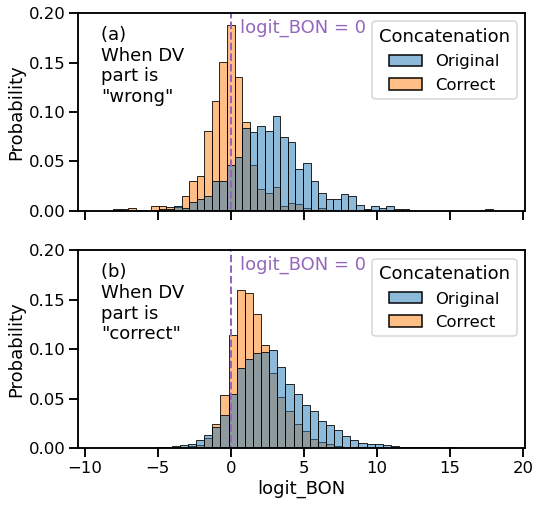

In [25]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
sns.histplot(data=df_all.query("logit_DV_ngrams_cosine < 0 and label == 1"),
    x="logit_BON", hue="Concatenation", bins=50,
    stat="probability", common_norm=False,
    ax=axs[0])
axs[0].text(0.05, 0.55, '(a) \nWhen DV \npart is \n"wrong"', transform=axs[0].transAxes)
sns.histplot(data=df_all.query("logit_DV_ngrams_cosine > 0 and label == 1"), 
    x="logit_BON", hue="Concatenation", bins=50,
    stat="probability", common_norm=False,
    ax=axs[1])
axs[1].text(0.05, 0.55, '(b) \nWhen DV \npart is \n"correct"', transform=axs[1].transAxes)
for ax in axs:
    ax.set_ylim([0, 0.2])
    ax.plot([[0], [0]], [[-25], [25]], '--', c=sns.color_palette(n_colors=10)[4], linewidth=2)
    ax.text(0.6, 0.18, "logit_BON = 0", color=sns.color_palette(n_colors=10)[4])
f.savefig("figures/logit_dist_compare_marginal.jpg")

plot_compare2 = sns.relplot(data=df_all.query("(logit_DV_ngrams_cosine > 0 or logit_BON > 0) and label == 0"), 
    x="logit_BON", y="logit_DV_ngrams_cosine", row="Concatenation",
    hue="Correctly Classified", palette="hls",
    s=10, height=8, aspect=1)
for ax in plot_compare2.axes.flat:
    ax.plot(intercept_line[:, 0], intercept_line[:, 1], c='r', linewidth=1.5)
    ax.plot([[-25, 0], [25, 0]], [[0, -25], [0, 25]], '--', c='gray', linewidth=1.5)
    ax.set(xlim=[-20, 10], ylim=[-15, 15])
plot_compare2.savefig("figures/logit_dist_compare2.jpg")

In [26]:
# delete the temp files
os.remove(filename_1gram)
os.remove(filename_embedding_train)
os.remove(filename_embedding_test)